In [4]:
from blastp import obtain_seq, write_to_fasta
from Bio.Blast.Applications import NcbiblastpCommandline
from Bio.Blast import NCBIXML
from Bio import SeqIO
from io import StringIO
import numpy as np
import os
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd
import matplotlib.pyplot as plt
from skbio.stats.distance import DistanceMatrix

def run_blast(query,subject,eval,out_format):
    output = NcbiblastpCommandline(
        query=query, subject=subject, outfmt=out_format,
        evalue=eval, num_alignments=500, num_descriptions=500)()[0]
    # read all parser result
    blast_result_record = list(NCBIXML.parse(StringIO(output)))
    return blast_result_record

def read_fasta(fasta_Seq):
    return [record for record in SeqIO.parse(fasta_Seq,"fasta")]

def dist_fun(discriptor):
    return 1 - ((2 * discriptor["Num_of_Identity"]) / \
        (discriptor["Align_Seq_Length"] + discriptor["Query_Seq_Length"]))

def label_obs(class_identifier, observation):
    chain_mutated_group = []
    size = observation.size
    for i in range(size):
        value_at_loc_i = observation[i]
        if isinstance(value_at_loc_i, str) and len(value_at_loc_i) > 6:
            chain = value_at_loc_i[0:6]
            component = value_at_loc_i.split('_')
            if len(component) > 2:
                chain_mutated_group.append(class_identifier[chain])

    return ",".join(chain_mutated_group)


def generate_dist_mat(fasta_Seq, dist_fun, dist_max, dist_unify_fun):
    # obtain the blast result
    blast_res = run_blast(fasta_Seq,fasta_Seq,1e20,5)
    # compile the result into a dictionary
    res_ct = 0
    blast_rs_dict = {}
    for query_seq in blast_res:
        query_seq_name = query_seq.query[0:6]
        blast_rs_dict[query_seq_name] = dict()
        # go through all alignments of all one sequence in query
        for alignment in query_seq.alignments:
            # subject seq (aligned sequence in database)'s name
            subjt_seq_name = alignment.title[0:6]
            
            # that contains significant alignment, usually there is only one)
            hsp_list = []
            for hsp in alignment.hsps:
                hsp_discriptor = {
                    "score": hsp.score,
                    "E_Value": hsp.expect,
                    "Bit_Score": hsp.bits,
                    "Query Cover": hsp.align_length/query_seq.query_length*100,
                    "Perc_Identity": hsp.identities/hsp.align_length*100,
                    "Num_of_Identity": hsp.identities,
                    "Aligned_length": hsp.align_length,
                    "Align_Seq_Length": alignment.length,
                    "Query_Seq_Length": query_seq.query_length,
                    "Subject_Name": subjt_seq_name,
                    "Query_Name": query_seq_name
                }
                hsp_list.append(hsp_discriptor)
            # set the result to be the best match based on bit score
            blast_rs_dict[query_seq_name][subjt_seq_name] = max(hsp_list, key=lambda x:x['Bit_Score'])
    seq_name = sorted([seq.name for seq in read_fasta(fasta_Seq)])
    dist_mat = []
    for query in seq_name:
        checking_set = set(blast_rs_dict[query].keys())
        query_dist = []
        for subjt in seq_name:
            if subjt in checking_set:
                discriptor = blast_rs_dict[query][subjt]
                query_dist.append(dist_fun(discriptor))
            else:
                query_dist.append(dist_max)
        dist_mat.append(query_dist)

    # validate distance matrix
    dist_mat = np.array(dist_mat)
    mat_size = dist_mat.shape[0]
    assert mat_size == dist_mat.shape[1], 'not a square matrix'
    scan_offset = 1
    for i in range(mat_size):
        for j in range(scan_offset, mat_size):
            if dist_mat[i,j] != dist_mat[j,i]:
                unify_dist = dist_unify_fun([dist_mat[i,j],dist_mat[j,i]])
                dist_mat[i, j], dist_mat[j, i] = unify_dist, unify_dist
        scan_offset += 1
    return seq_name, dist_mat



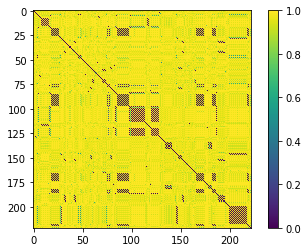

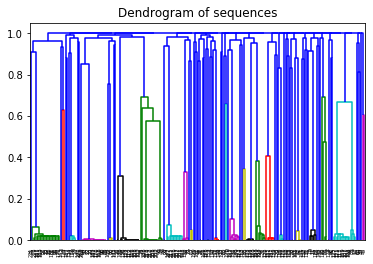

        0       1                 2       3          4          5         6  \
0  1A22_A  1A22_B   1A22_A_SER51ALA  1A22_B -12.333753 -11.985693  0.348060   
1  1A22_A  1A22_B  1A22_A_PHE165ALA  1A22_B -12.333753 -11.923303  0.410450   
2  1A22_A  1A22_B   1A22_A_SER62ALA  1A22_B -12.333753 -12.178393  0.155360   
3  1A22_A  1A22_B  1A22_A_ILE168ALA  1A22_B -12.333753 -11.527845  0.805908   
4  1A22_A  1A22_B   1A22_A_GLN22ALA  1A22_B -12.333753 -12.553480 -0.219727   

  class  
0    57  
1    57  
2    57  
3    57  
4    57  


In [6]:

def main():
    if not os.path.exists('./fasta_db'):
        os.mkdir('./fasta_db')

    if not os.path.exists('./RES'):
        os.mkdir('./RES')
    
    # skempi_v1 = obtain_seq('SKP1402m.ddg.txt', 'SKP1402m.seq.txt')
    skempi_v1 = obtain_seq('SKP1102s.ddg.txt', 'SKP1102s.seq.txt')

    write_to_fasta(skempi_v1, './fasta_db/skempi_v1_SKP1102s.fasta')
    chain_name, dist_mat = generate_dist_mat(fasta_Seq='./fasta_db/skempi_v1_SKP1102s.fasta',\
                                             dist_fun=dist_fun,dist_max=1,dist_unify_fun=min)

    # plot the distance matrix
    plt.imshow(dist_mat)
    plt.colorbar()
    plt.show()
    
    # To change linkage, specify linkage="complete" to linkage="single" or linkage="average"
    # the difference in the linkage can be found at
    # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html, at comments of parameter linkage

    # Now cluster those that with identity > 25% together following the reviwer's comment
    # you can also choose to specify n_cluster, but then distance_threshold will need to be None
    # Just the uncomment the following two lines
#     Agg_cluster = AgglomerativeClustering(n_clusters=10, affinity="precomputed",
#                                           linkage="complete", compute_full_tree=True, distance_threshold=None)
    Agg_cluster = AgglomerativeClustering(n_clusters=None, affinity="precomputed", \
                                          linkage="complete", compute_full_tree=True, distance_threshold=0.75)
    Agg_cluster.fit(dist_mat)

    # plot dendrogram
    cnd_dist_mat = DistanceMatrix(dist_mat).condensed_form()
    L = linkage(cnd_dist_mat,method='complete')
    plt.title('Dendrogram of sequences')
    dendrogram(L)
    plt.show()
    
    # save the result
    result = pd.DataFrame({"Chain":chain_name,"label":Agg_cluster.labels_})
    result.to_csv('./RES/SKP1102s_cluster_label.csv',index=False)
    check_dict = {k:str(v) for k,v in zip(chain_name,Agg_cluster.labels_)}

    # read in the skempi_v1 dataset and add the additional column
    # dataset = pd.read_csv('dataFile/SKP1402m.ddg.txt', sep='\t', header=None)
    dataset = pd.read_csv('dataFile/SKP1102s.ddg.txt', sep='\t', header=None)

    identifier_col = []
    for _, row in dataset.iterrows():
        identifier_col.append(label_obs(check_dict,row))
    dataset['class'] = identifier_col
    print(dataset.head())

    dataset.to_csv('./RES/SKP1102s.ddg_class.txt',sep='\t',index=False,header=False)
    
    return 

# if __name__ == "__main__":
main()
